In [1]:
import xarray as xr
import numpy as np 
import pandas as pd
import metpy.calc as mpc
from metpy.units import units

import matplotlib.pyplot as plt 


## Read in data

In [2]:
# Define file names 
dataDir  = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/'

z3file   = dataDir+'daily/f.e20.FHIST.f09_f09.cesm2_1.001.cam.h1.2000_Z3.nc'
varsFile = dataDir+'daily/f.e20.FHIST.f09_f09.cesm2_1.001.cam.h1.2000_RiVars.nc'
topoFile = dataDir+'fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
pressFile = dataDir+'daily/f.e20.FHIST.f09_f09.cesm2_1.001.cam.h1.2000_PresLevs.nc'


In [3]:
# Open files into datasets 
z3_ds         = xr.open_dataset(z3file, decode_times=True)
z3_ds['time'] = z3_ds.indexes['time'].to_datetimeindex()

varsDS         = xr.open_dataset(varsFile, decode_times=True)
varsDS['time'] = varsDS.indexes['time'].to_datetimeindex()

pressDS         = xr.open_dataset(pressFile, decode_times=True)
pressDS['time'] = pressDS.indexes['time'].to_datetimeindex()

topo_ds         = xr.open_dataset(topoFile, decode_times=True)


<ipython-input-3-0c83a03feec1>:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  z3_ds['time'] = z3_ds.indexes['time'].to_datetimeindex()
<ipython-input-3-0c83a03feec1>:6: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  varsDS['time'] = varsDS.indexes['time'].to_datetimeindex()
<ipython-input-3-0c83a03feec1>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
 

In [30]:
varsDS

<xarray.Dataset>
Dimensions:    (ilev: 33, lat: 192, lev: 7, lon: 288, nbnd: 2, time: 360)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev        (lev) float64 3.643 7.595 14.36 24.61 35.92 43.19 51.68
  * ilev       (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time       (time) datetime64[ns] 2000-01-26 2000-01-27 ... 2001-01-20
Dimensions without coordinates: nbnd
Data variables:
    hyam       (lev) float64 0.003643 0.007595 0.01436 ... 0.04319 0.05168
    hybm       (lev) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    P0         float64 1e+05
    hyai       (ilev) float64 0.002255 0.005032 0.01016 ... 0.003979 0.0 0.0
    hybi       (ilev) float64 0.0 0.0 0.0 0.0 0.0 ... 0.9389 0.9636 0.9851 1.0
    time_bnds  (time, nbnd) object 2000-01-25 00:00:00 ... 2001-01-20 00:00:00
    PS         (time, lat, lon) float32 ...
    Q          (time, lev, lat, lon) float32 ...
    T          (time, lev, lat, lon) float32 268.6 268.6 268.6 ... 199.3 199.3
    U          (time, lev, lat, lon) float32 3.276 3.264 3.25 ... -40.98 -41.22
    V          (time, lev, lat, lon) float32 0.5283 0.5996 ... -11.56 -10.66
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              f.e20.FHIST.f09_f09.cesm2_1.001
    logname:           hannay
    host:              cheyenne1
    initial_file:      b.e21.BHIST.f09_g17.CMIP6-historical.001.cam.i.1950-01...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  day_1
    history:           Thu Dec 17 14:15:00 2020: ncrcat -v U,V,T,PS,Q f.e20.F...
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....

In [6]:
# Limit to levels with pressures >850.0 hPa 
iLev = np.where(z3_ds.lev.values > 850.0)[0]

z3_ds   = z3_ds.isel(lev=iLev)
varsDS  = varsDS.isel(lev=iLev)
pressDS = pressDS.isel(lev=iLev)


In [7]:
# Read in a land mask at the same resolution 
testName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/f.e20.FHIST.f09_f09.cesm2_1.001.clm2.h0.1989-12.nc'
testDF   = xr.open_dataset(testName)

# Make land mask
landMask              = testDF.landmask.values
landMask[landMask==0] = np.nan

np.shape(landMask)

(192, 288)

In [8]:
# Get height (above ground level)
Z3   = z3_ds.Z3.values*landMask
PHIS = topo_ds.PHIS.values*landMask

# Convert geopotential into geopotential height of surface
PHIS = PHIS/9.81

# Force PHIS to have same dimensions as Z3 
PHISnew1 = np.repeat(PHIS[np.newaxis, :,:],np.shape(Z3)[1],axis=0)
PHISnew  = np.repeat(PHISnew1[np.newaxis,:,:,:],np.shape(Z3)[0],axis=0)
print('Shape of Z3:   ', np.shape(Z3))
print('Shape of PHIS: ', np.shape(PHISnew))

# Height agl is then just Z3 - PHISnew
z_agl = (Z3 - PHISnew) * units.meters


Shape of Z3:    (360, 7, 192, 288)
Shape of PHIS:  (360, 7, 192, 288)


In [9]:
# Get potential temperature 
P = (pressDS.PRESSURE.values*landMask) * units('Pa')
T = (varsDS.T.values*landMask)         * units('K')

potTemp = mpc.potential_temperature(P,T)


In [10]:
np.shape(potTemp)

(360, 7, 192, 288)

In [11]:
np.shape(varsDS.lat.values)

(192,)

In [12]:
# Clear variables from memory that aren't needed anymore
del PHISnew
del PHIS 
del Z3 
del P
del T 
del pressDS
del z3_ds
del topo_ds
del testDF


In [14]:
# Compute gradient richardson number
U = (varsDS.U.values) * units('m/s')
V = (varsDS.V.values) * units('m/s')

print('Computing Ri...')

# Ri = np.full([], np.nan)

# for iLat in range(len(varsDS.lat.values)):
#     for iLon in range(len(varsDS.lon.values)):
Ri = mpc.gradient_richardson_number(z_agl, potTemp, U, V, 1)


Computing Ri...


In [42]:
import metpy.units as mpu

mpu.signature(Ri)

TypeError: <Quantity([[[[   387.59974016    387.5995369     387.59967507 ...    387.59969173
       387.59971675    387.59954884]
   [   656.07865957    656.9856762     657.55661233 ...    651.46335952
       653.31554711    654.85024553]
   [  1655.74736079   1691.73416003   1726.18612505 ...   1542.31683569
      1580.70452133   1618.61582485]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[  2989.63404951   2989.6329269    2989.63300021 ...   2989.6326381
      2989.63265123   2989.63371968]
   [ 14232.89994138  13670.49595321  13128.83830514 ...  16035.57718854
     15417.1944719   14815.51390675]
   [  7883.13949874   7680.07400769   7488.38779169 ...   8573.83402549
      8328.58631487   8098.8488962 ]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[  6311.96949688   6311.97008118   6311.97004168 ...   6311.96918445
      6311.96927374   6311.96929692]
   [  3973.57939597   3908.61068626   3846.76337967 ...   4189.27581864
      4113.75303934   4041.88102388]
   [  1546.83086058   1529.80816831   1513.67805208 ...   1603.70895559
      1583.74118546   1564.79382006]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  ...

  [[  1253.67075024   1253.67056311   1253.67025115 ...   1253.67033825
      1253.67025863   1253.67063037]
   [  1161.52093556   1158.18418918   1155.12143219 ...   1173.33950074
      1169.10365074   1165.15313665]
   [  1613.34340448   1595.26124319   1578.43486028 ...   1675.12597564
      1653.2881928    1632.68414987]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[  1831.59802992   1831.59821828   1831.59875603 ...   1831.5990013
      1831.5995463    1831.59866763]
   [  2064.75045574   2040.54822264   2016.72110457 ...   2139.92431972
      2114.45583367   2089.37394367]
   [  3323.08269341   3240.03955913   3161.09648004 ...   3599.02269894
      3502.38619422   3410.45942919]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[ 11077.80727505  11077.80214468  11077.80891722 ...  11077.80278566
     11077.82085296  11077.7898949 ]
   [119730.72792141 107513.00346501  96411.06436571 ... 163466.27854006
    147672.81893474 133107.48991578]
   [ 54313.97377005  53863.58521041  53317.0422482  ...  55092.36258992
     54934.4764177   54673.13871384]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]]


 [[[   452.15189469    452.15163396    452.15177342 ...    452.15171483
       452.15155206    452.15164796]
   [   766.43141014    764.12298503    761.52407316 ...    771.62839817
       770.19676245    768.45320722]
   [  2142.69192083   2127.95724216   2108.15142417 ...   2154.44099037
      2156.04759605   2152.10763389]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[  4668.38805612   4668.39105879   4668.38983707 ...   4668.38921151
      4668.38833775   4668.38997023]
   [ 22743.88521292  21499.24136363  20346.36376607 ...  27124.3921064
     25546.52892826  24089.57349117]
   [  8001.31582717   7900.29200943   7797.34574713 ...   8297.79415244
      8199.58608353   8100.92417979]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[ 46574.81730609  46574.81975104  46574.81452472 ...  46574.82359353
     46574.79074175  46574.77217218]
   [  5370.89571809   5367.57526967   5367.21260992 ...   5400.6594659
      5387.34535504   5377.40515717]
   [  1654.53575622   1656.56533308   1659.58059727 ...   1654.4633201
      1653.48557557   1653.50321493]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  ...

  [[  1288.12464348   1288.12385679   1288.12500006 ...   1288.12426427
      1288.12444869   1288.12433442]
   [  1407.32947938   1390.34019102   1373.99696938 ...   1462.56463877
      1443.43364104   1425.01427532]
   [  2616.9988158    2538.60699229   2463.50473075 ...   2871.88766668
      2783.69261701   2698.69893973]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[  1749.22172735   1749.22285524   1749.22257923 ...   1749.22207929
      1749.22266801   1749.22315809]
   [  2040.01782318   2031.72731421   2023.88794766 ...   2067.67949189
      2058.03621891   2048.78567649]
   [  3678.96822763   3645.65500855   3609.9427618  ...   3763.00536594
      3737.79126905   3709.72487955]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[  5186.36732514   5186.39119354   5186.37457211 ...   5186.3731326
      5186.38308939   5186.37714894]
   [  4018.57479165   4144.71564577   4276.08490015 ...   3666.44897276
      3779.90419665   3897.08745731]
   [  2586.56110963   2771.99009677   2973.94861985 ...   2119.79784944
      2261.45253521   2416.70194574]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]]


 [[[   364.73047451    364.73057307    364.7305523  ...    364.73036987
       364.73035904    364.73037892]
   [   549.1206992     545.59385204    541.98628354 ...    559.23675545
       555.95268649    552.57216664]
   [  1155.78556097   1129.21165388   1102.3306737  ...   1231.87728684
      1207.32314648   1181.8890827 ]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[  4526.6124485    4526.61371229   4526.61467597 ...   4526.61662864
      4526.61439959   4526.61321967]
   [ 26911.87779546  25302.08604121  23813.9278265  ...  32589.91064887
     30544.07859435  28654.72516717]
   [ 15377.93141666  15161.36752627  14902.3335555  ...  15760.15876767
     15677.60069228  15550.26952992]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[ 62833.58389634  62833.68235839  62833.56406452 ...  62833.56189535
     62833.51156921  62833.59083111]
   [  5967.18706378   6056.19670764   6150.26317588 ...   5730.29668964
      5804.37808531   5883.24922649]
   [  1930.04750567   1956.29135457   1984.36681454 ...   1862.11389559
      1882.99466731   1905.62197602]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  ...

  [[  1289.28290345   1289.28348229   1289.2836213  ...   1289.28350975
      1289.28376727   1289.28310804]
   [  1494.52515554   1478.47051132   1462.73932412 ...   1544.85007822
      1527.72467036   1510.93491904]
   [  2322.75068559   2280.49017485   2238.08224183 ...   2447.42742995
      2406.36910949   2364.75420715]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[   928.04247285    928.0419041     928.04234757 ...    928.04226505
       928.04224522    928.04242239]
   [   887.02345226    890.4728511     894.2257631  ...    878.60409688
       881.08902096    883.89082229]
   [  1304.27582956   1299.1155886    1294.31330413 ...   1321.36744735
      1315.45566056   1309.73369754]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[   731.09181911    731.08957851    731.09075335 ...    731.09073574
       731.08977124    731.09121917]
   [   399.21612851    405.63337215    412.56256926 ...    382.86537314
       387.85585858    393.29496984]
   [   570.77910346    576.37887697    582.95969876 ...    559.09684913
       562.20318666    566.07289331]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]]


 ...


 [[[ 10330.30534921  10330.30316122  10330.30548399 ...  10330.30286953
     10330.30603823  10330.30225123]
   [ 60075.10205903  58102.98079707  55818.32448646 ...  63362.05650751
     62769.14210186  61654.63036929]
   [  3084.09874019   3087.81876644   3089.11558359 ...   3059.91684934
      3070.08911563   3078.14554583]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[ 10590.24845533  10590.24957149  10590.24944195 ...  10590.2497372
     10590.24802257  10590.24862194]
   [ 17828.48637933  18685.51921494  19610.25092348 ...  15602.86512239
     16292.7979527   17032.78183969]
   [  4331.70443686   4414.42777319   4499.22911191 ...   4095.79445501
      4172.45837759   4251.06121007]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[  4156.60255289   4156.60169695   4156.6018037  ...   4156.60272049
      4156.60128845   4156.60258037]
   [  3846.97403804   3892.59940658   3939.22446549 ...   3716.17705781
      3758.83641036   3802.38003156]
   [  2887.7284747    2934.54083576   2982.72356168 ...   2755.19277879
      2798.11953093   2842.2585078 ]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  ...

  [[  1279.32091923   1279.32101276   1279.32104324 ...   1279.32087433
      1279.32104737   1279.32105464]
   [   994.11147727    997.18434585   1000.24542238 ...    984.89886816
       987.95912743    991.03145374]
   [   944.91101697    950.41342272    955.80853895 ...    927.59689473
       933.49243303    939.28431564]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[  1373.56187498   1373.56181726   1373.56194905 ...   1373.56177532
      1373.56173424   1373.56145938]
   [   993.22702341    995.89214396    998.74428292 ...    986.2822849
       988.40887883    990.72618272]
   [   784.52007393    782.90452243    781.60665648 ...    790.86352697
       788.4676445     786.36988742]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[  1692.71592042   1692.71561874   1692.71554616 ...   1692.71579621
      1692.7156513    1692.71443442]
   [  1212.72108735   1215.24942832   1218.20457344 ...   1207.46263876
      1208.78557586   1210.5400467 ]
   [   871.00452732    865.32185689    860.56945628 ...    892.93731825
       884.71296751    877.41691097]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]]


 [[[  9228.87055707   9228.87433814   9228.87182907 ...   9228.87260409
      9228.87342216   9228.87247374]
   [ 10285.81903004   9787.85184382   9324.67614406 ...  12024.75701882
     11400.2095542   10822.12804159]
   [  2094.46562871   2058.13267299   2021.91551535 ...   2203.88010247
      2167.38793382   2130.98103735]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[ 20967.05520567  20967.05631203  20967.05682326 ...  20967.0524501
     20967.05622695  20967.0555945 ]
   [ 50438.83522945  52862.27517485  55328.33912531 ...  43595.14042104
     45792.86463265  48077.51802172]
   [  5261.23012581   5291.8297726    5319.93109833 ...   5156.36720928
      5193.38967321   5228.53911226]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[  6274.77759037   6274.7778575    6274.77716818 ...   6274.77663185
      6274.77717315   6274.77712339]
   [  4670.40443867   4743.01020244   4817.78830981 ...   4465.94666924
      4531.92999687   4600.01891234]
   [  2923.97399399   2966.87233199   3011.77589283 ...   2805.73243532
      2843.47593451   2882.81298225]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  ...

  [[  1385.13819255   1385.13810045   1385.13817468 ...   1385.13817989
      1385.13796955   1385.137938  ]
   [   962.72755026    968.42051033    974.28613336 ...    946.81202724
       951.94605305    957.2372741 ]
   [   764.34752773    769.41898125    774.62007345 ...    749.67782576
       754.47537731    759.35867635]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[  1170.41013401   1170.40965878   1170.40979881 ...   1170.4098835
      1170.40996596   1170.40973033]
   [   866.39943737    870.48644783    874.72109231 ...    855.16935735
       858.7598537     862.4911111 ]
   [   657.17451554    660.50967883    664.13159999 ...    648.78563773
       651.30839245    654.09998817]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[  1048.09649642   1048.0966087    1048.09626567 ...   1048.09696074
      1048.09720462   1048.09677946]
   [   862.74027295    864.95281467    867.30401219 ...    857.24536074
       858.8852341     860.71071499]
   [   707.98226481    709.34160042    711.2639417  ...    707.32943691
       706.96500507    707.17982657]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]]


 [[[  5043.56628657   5043.5694475    5043.56797446 ...   5043.56527654
      5043.56607052   5043.56806   ]
   [  4017.03157876   3867.55907855   3726.9278378  ...   4526.91231271
      4345.88679484   4176.17435343]
   [  1297.29250633   1266.32756724   1236.59124164 ...   1398.19820781
      1363.1732926    1329.55210267]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[ 29360.05256142  29360.04819782  29360.05069995 ...  29360.05360046
     29360.04981497  29360.05136414]
   [ 44981.83160735  44050.47908029  43044.0525862  ...  47203.67014814
     46569.83571818  45824.9576566 ]
   [  4604.86365523   4573.58539123   4540.84174866 ...   4690.01846367
      4663.11083366   4634.69733132]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[  4536.35266079   4536.35307884   4536.35206881 ...   4536.35169104
      4536.35191621   4536.35178587]
   [  4308.98350558   4384.54037705   4462.43391332 ...   4095.99494241
      4164.84292946   4235.77202398]
   [  2924.65013061   2993.49876613   3066.17935786 ...   2739.38245337
      2797.78187272   2859.46542773]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  ...

  [[  1450.88446385   1450.88473049   1450.88494728 ...   1450.88482306
      1450.88471929   1450.88490008]
   [  1070.1608243    1077.61449334   1085.28842419 ...   1049.10365946
      1055.9356828    1062.93508256]
   [   745.12577341    752.40306137    760.02105441 ...    725.29701972
       731.58128497    738.18344219]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[  1435.50120951   1435.50149826   1435.50169483 ...   1435.50131468
      1435.50117739   1435.50122672]
   [  1072.28765917   1077.36897219   1082.55506964 ...   1057.71726556
      1062.48776138   1067.332431  ]
   [   850.36105564    857.86052819    865.66061174 ...    829.57529869
       836.22671038    843.15145084]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]

  [[  1336.67776017   1336.67688666   1336.67781569 ...   1336.67690034
      1336.67722323   1336.67694438]
   [  1093.94030052   1095.06710259   1096.18549214 ...   1090.66332771
      1091.74450838   1092.83978848]
   [  1238.19155526   1245.37040744   1253.10705365 ...   1219.50891472
      1225.28021669   1231.50805807]
   ...
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]
   [            nan             nan             nan ...             nan
                nan             nan]]]], 'dimensionless')> is not a callable object

In [15]:
np.shape(Ri)

(360, 7, 192, 288)

In [37]:
np.shape(varsDS.lev.values)

(7,)

<ipython-input-36-6c02db5fe8ef>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(varsDS.lon.values,varsDS.lat.values,np.squeeze(Ri[200,-1,:,:]),


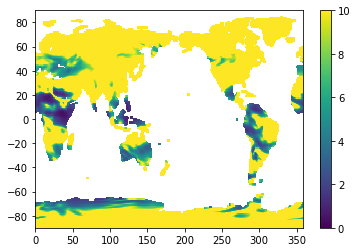

In [36]:
plt.pcolormesh(varsDS.lon.values,varsDS.lat.values,np.squeeze(Ri[200,-1,:,:]), 
                vmax=10,vmin=0)
plt.colorbar()

In [27]:
iLim = np.where(Ri<=0.25)[0]
iLim

array([  0,   0,   0, ..., 359, 359, 359])